<a href="https://colab.research.google.com/github/2303A51236/ADM_ProjectReport/blob/main/Stroke_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

# Load dataset
df = pd.read_csv('test_2v.csv')

# Handle missing values properly (avoid chained assignment warning)
df['bmi'] = df['bmi'].fillna(df['bmi'].median())
df['smoking_status'] = df['smoking_status'].fillna('Unknown')

# Create synthetic target variable
df['stroke_risk'] = (
    (df['hypertension'] == 1) |
    (df['heart_disease'] == 1) |
    (df['avg_glucose_level'] > 140) |
    (df['bmi'] > 30) |
    (df['age'] > 50) |
    (df['smoking_status'].isin(['formerly smoked', 'smokes']))
).astype(int)

# Features and target
X = df.drop(['stroke_risk', 'id'], axis=1)
y = df['stroke_risk']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipelines
numeric_features = ['age', 'avg_glucose_level', 'bmi']
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                        'work_type', 'Residence_type', 'smoking_status']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Model pipeline
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Predictions and evaluation
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Accuracy: 0.9389948938457404

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      1160
           1       0.98      0.93      0.95      2561

    accuracy                           0.94      3721
   macro avg       0.92      0.94      0.93      3721
weighted avg       0.94      0.94      0.94      3721

Mean Squared Error: 0.06100510615425961


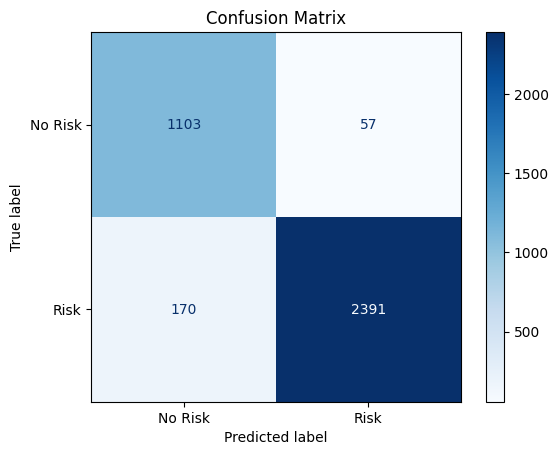

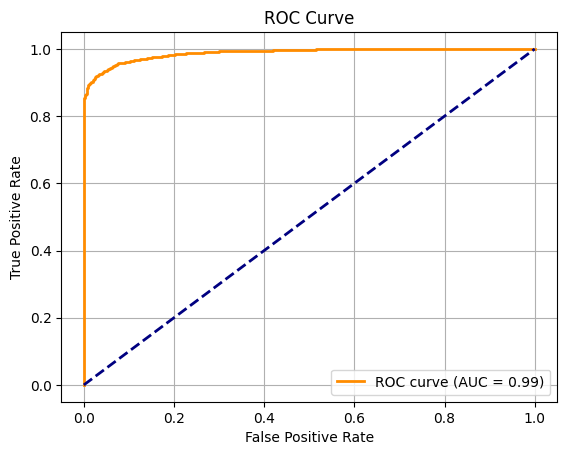

<ipython-input-2-c05c9a61a4c9>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='stroke_risk', palette='Set2')


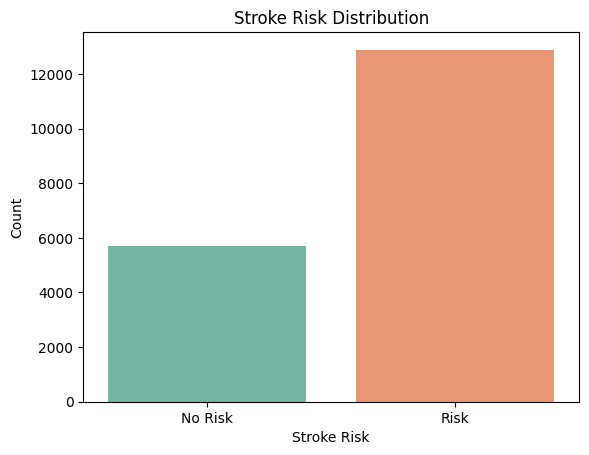

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Risk", "Risk"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
y_proba = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
sns.countplot(data=df, x='stroke_risk', palette='Set2')
plt.title('Stroke Risk Distribution')
plt.xticks([0, 1], ['No Risk', 'Risk'])
plt.xlabel('Stroke Risk')
plt.ylabel('Count')
plt.show()


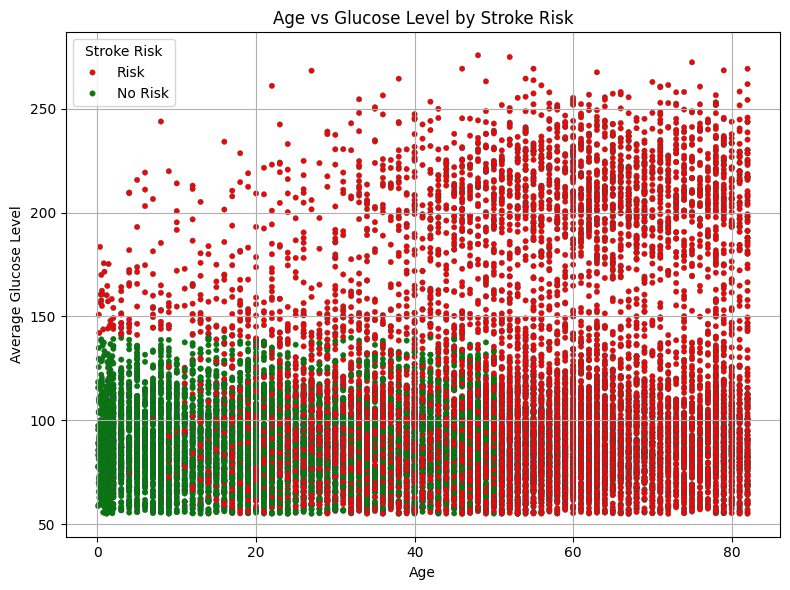

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map stroke_risk to color labels
df['stroke_risk_label'] = df['stroke_risk'].map({0: 'No Risk', 1: 'Risk'})

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='age',
    y='avg_glucose_level',
    hue='stroke_risk_label',
    palette={'No Risk': 'green', 'Risk': 'red'},
    edgecolor='darkslategrey',
    s=15
)

plt.title('Age vs Glucose Level by Stroke Risk')
plt.xlabel('Age')
plt.ylabel('Average Glucose Level')
plt.legend(title='Stroke Risk')
plt.grid(True)
plt.tight_layout()
plt.show()
